In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [15]:
# Load results of the fitting procedure

subject = 1
volume_space=True
feature_type_list_long = ['semantic_discrim_raw','gabor_solo_ridge_12ori_8sf',\
                 'texture_pyramid_ridge_4ori_4sf','sketch_tokens',\
                 'alexnet_all_conv_pca', 'clip_RN50_all_resblocks_pca']
feature_type_list = ['raw','gabor',\
                 'texture_pyramid','sketch_tokens',\
                 'alexnet', 'clip']
# fitting_types = ['semantic_animacy','gabor_solo_ridge_12ori_8sf','sketch_tokens', 'alexnet_all_conv']

nf = [0,0,0,0,0,0]
discrim = []
outlist = []
root = os.path.dirname(os.path.dirname(os.getcwd()))
for fi, fitting_type in enumerate(feature_type_list_long):
    out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                      n_from_end=nf[fi], root=root, verbose=True);
#     load_fits.print_output_summary(out)
    print(out['which_prf_grid'])
    print(out['up_to_sess'])
    discrim.append(out['discrim_each_axis'])
    outlist.append(out)
    
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/semantic_discrim_raw/Nov-15-2021_2105_33/all_fit_params

dict_keys(['subject', 'volume_space', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'debug', 'up_to_sess', 'single_sess', 'prf_fit_filename', 'discrim_each_axis'])
5
40
loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Dec-10-2021_1208_11/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 

In [ ]:
discrim_type_list =['animacy','indoor_outdoor', 'person', 'animal','food','vehicle']

trn_acc = np.zeros((len(feature_type_list), len(discrim_type_list), n_prfs))
trn_dprime= np.zeros((len(feature_type_list), len(discrim_type_list), n_prfs))
val_acc = np.zeros((len(feature_type_list), len(discrim_type_list), n_prfs))
val_dprime = np.zeros((len(feature_type_list), len(discrim_type_list), n_prfs))

for ff, feature_type in enumerate(feature_type_list):

    path_to_load = os.path.join(feature_folders[ff], 'LDA')

    for dd, discrim_type in enumerate(discrim_type_list):
        fn2save = os.path.join(path_to_load, \
                           'S%d_%s_LDA_%s_grid%d.npy'%(subject, feature_type, discrim_type, which_prf_grid))

        print('loading from %s'%fn2save)
        lda_result = np.load(fn2save,allow_pickle=True).item()
        trn_acc[ff,dd,:] = np.array(lda_result['trn_acc'])
        trn_dprime[ff,dd,:] = np.array(lda_result['trn_dprime'])
        val_acc[ff,dd,:] = np.array(lda_result['val_acc'])
        val_dprime[ff,dd,:] = np.array(lda_result['val_dprime'])


In [49]:
[outlist[ii]['up_to_sess'] for ii in range(len(outlist))]

[40, 40, 40, 40, 40, 10]

In [51]:
[np.any(np.isnan(outlist[ii]['discrim_each_axis']), axis=0)  for ii in range(len(outlist))]

[array([False, False, False, False, False, False]),
 array([False, False, False, False, False, False]),
 array([False, False, False, False, False, False]),
 array([False, False, False, False, False, False]),
 array([False, False, False, False, False, False]),
 array([False, False, False,  True,  True, False])]

In [87]:
bad = np.where(np.isnan(outlist[5]['discrim_each_axis'][:,3]))
not_bad = np.where(~np.isnan(outlist[5]['discrim_each_axis'][:,3]))

In [83]:
bad = np.where(np.isnan(outlist[5]['discrim_each_axis'][:,4]))
not_bad = np.where(~np.isnan(outlist[5]['discrim_each_axis'][:,4]))

In [84]:
out['best_params'][5][bad,0]

array([[128, 128, 128, 128, 128]])

In [85]:
np.any(out['best_params'][5][not_bad,0]==128)

False

In [90]:
outlist[1]['best_params'][5][bad,0]

array([[128, 128, 129, 129, 129, 129, 128, 129, 129, 129, 129, 129, 129,
        128, 129, 129, 129, 128, 129]])

In [85]:
np.any(out['best_params'][5][not_bad,0]==128)

False

In [70]:
out['val_cc'][bad,0]

array([[ 0.04893054, -0.003361  ,  0.00559501,  0.00127963,  0.00193743,
        -0.05104493, -0.04398076, -0.01576977, -0.06182363, -0.01365268,
         0.01671274, -0.00194212, -0.03262223,  0.38692802,  0.00539918,
         0.02683328, -0.0045927 ,  0.02089827,  0.08893929]],
      dtype=float32)

In [76]:
out['corr_each_feature'][0,:]

array([-0.02055573,  0.21953706,  0.27663563, ...,         nan,
               nan,         nan])

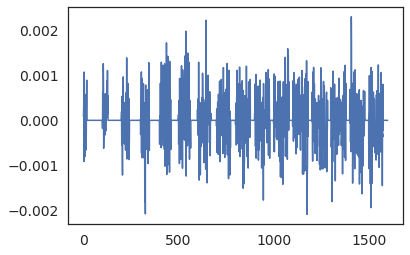

In [60]:
wts = outlist[5]['best_params'][1][1801,:,0]
plt.figure();
plt.plot(wts)

In [62]:
retlabs[1801]

3.0

In [4]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def

nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)
roi_names = ret_names+face_names+place_names+body_names

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


In [41]:
areas2plot = np.array([0,1,2,3,6,13,14,17,18,20,21])
print(np.array(roi_names)[areas2plot])
print(np.array(roi_names)[~np.isin(np.arange(len(roi_names)), areas2plot)])

['V1' 'V2' 'V3' 'hV4' 'LO1-2' 'FFA-1' 'FFA-2' 'OPA' 'PPA' 'EBA' 'FBA-1']
['VO1-2' 'PHC1-2' 'TO1-2' 'V3ab' 'IPS0-5' 'SPL1' 'FEF' 'OFA' 'mTL-faces'
 'aTL-faces' 'RSC' 'FBA-2' 'mTL-bodies']


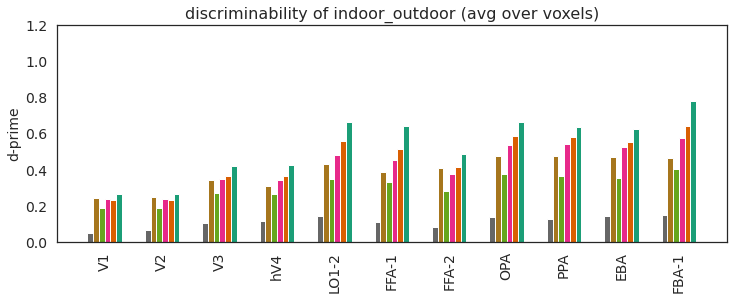

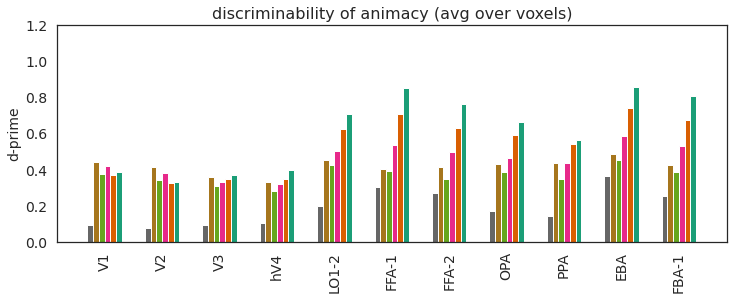

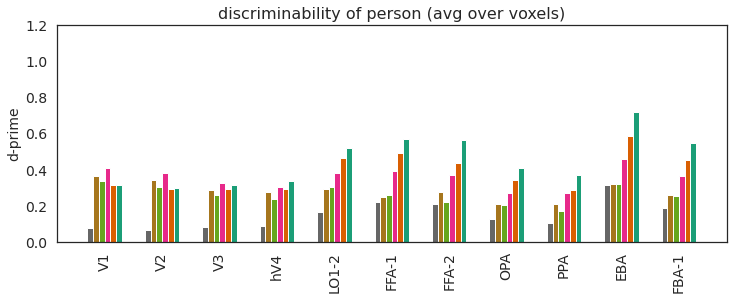

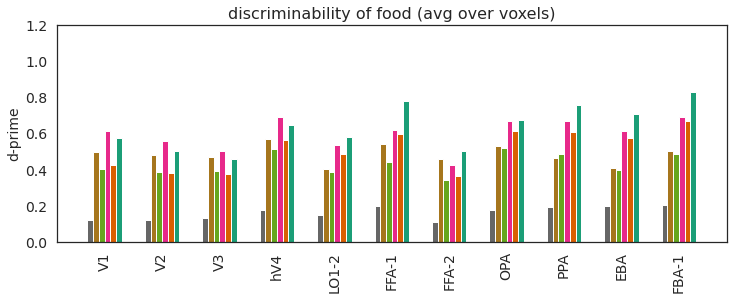

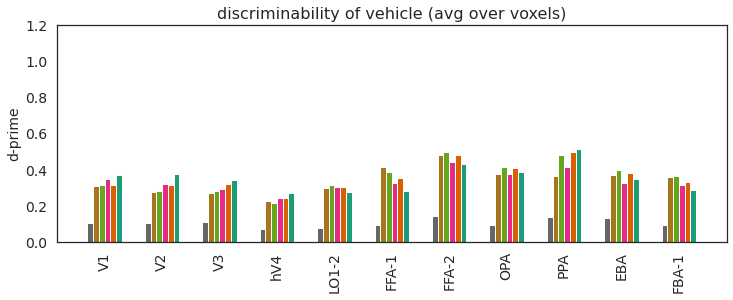

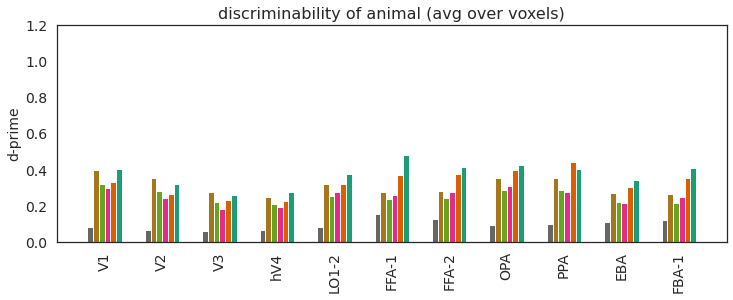

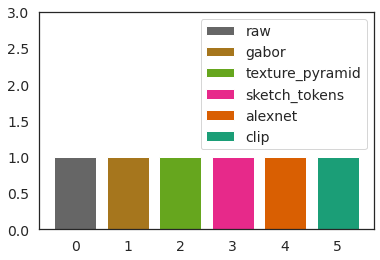

In [96]:

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))

discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
n_sem_axes = len(discrim_type_list)
mean_discrim_each_roi = np.zeros((len(fitting_types),n_rois, n_sem_axes))
sem_discrim_each_roi = np.zeros((len(fitting_types),n_rois, n_sem_axes))

for ff in range(len(fitting_types)):
    for rr in range(n_rois):
        if rr in areas2plot:
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            mean_discrim_each_roi[ff,rr,:] = np.nanmean(np.abs(discrim[ff][inds_this_roi,:]), axis=0)
            sem_discrim_each_roi[ff,rr,:] = np.nanstd(np.abs(discrim[ff][inds_this_roi,:]), \
                                                      axis=0)/np.sqrt(np.sum(inds_this_roi))
        else:
            mean_discrim_each_roi[ff,rr,:] = np.nan

bar_jitters = np.linspace(-0.25, 0.25,len(fitting_types))
bar_width = np.diff(bar_jitters[0:2])[0]
for aa, discrim_type in enumerate(discrim_type_list):
    plt.figure(figsize=(12,4));
    inds2use = np.isin(np.arange(n_rois), areas2plot)
    n_rois_plot = np.sum(inds2use)
    for fi in range(len(fitting_types)):
        plt.bar(np.arange(n_rois_plot)+bar_jitters[fi],mean_discrim_each_roi[fi,inds2use,aa],\
                width=bar_width, color=feature_colors[fi,:])
#         plt.errorbar(np.arange(n_rois_plot)+bar_jitters[fi],mean_discrim_each_roi[fi,inds2use,aa],\
#                      sem_discrim_each_roi[fi,inds2use,aa], ecolor='k', \
#                     ls='none',zorder=10)
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[inds2use], rotation=90);
    plt.ylabel('d-prime')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,1.2])

plt.figure();
for aa, discrim_type in enumerate(discrim_type_list):
    plt.bar([aa],[1],color=feature_colors[aa,:])
plt.ylim([0,3])
plt.legend(feature_type_list)

In [48]:
mean_discrim_each_roi[:,0,4]

array([0.10729276, 0.3136233 , 0.31563358, 0.35209018, 0.31874821,
              nan])

In [32]:
inds2use.shape

(24,)

In [33]:
mean_discrim_each_roi.shape

(6, 24, 6)

In [7]:
# Make plots in pycortex for variance partitioning analysis

import cortex
import copy
port=53333

out = outlist[3]
# fitting_type = fitting_types[0]

maps = []
names = []
cmaps = []
mins = []
maxes =[]

vox2plot = np.ones((out['discrim_each_axis'].shape[0],))==1
# vox2plot = out['val_r2'][:,0]>0

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out);
print([np.max(best_ecc_deg), np.max(best_size_deg)])
names = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [7, 360, 8.4]


# maps += [np.sqrt(out['val_r2'][:,0])]
# names += ['sketch tokens model R2 (sqrt)']
# cmaps += ['PuBu']
# mins += [0]
# maxes += [0.6]

for fi, fitting_type in enumerate(fitting_types):
    out = outlist[fi]
    discrim_each_axis = copy.deepcopy(out['discrim_each_axis'])
    discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
    n_sem_axes = len(discrim_type_list)
    maps += [discrim_each_axis[:,dd] for dd in range(n_sem_axes)]
    names += ['%s: dprime: %s'%(fitting_type, dd) for dd in discrim_type_list]
    cmaps += ['RdBu' for dd in range(n_sem_axes)]
    mins += [-1.5 for dd in range(n_sem_axes)]
    maxes += [1.5 for dd in range(n_sem_axes)]

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type=fitting_types[0], \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)

[6.9999995, 8.4]
Data is in 3d volume space
navigate browser to: 127.0.0.1:53333
Started server on port 53333
